In [1]:
import os
import random
import numpy as np
import tensorflow as tf


seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

print(f"Reproductibilité activée: seed={seed}")

2026-01-12 09:49:23.647029: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-12 09:49:23.655994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 09:49:24.077184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 09:49:27.548156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computat

Reproductibilité activée: seed=42


In [2]:
from tensorflow import keras
from keras import layers, models
import pyarrow as pa
import pyarrow.parquet as pq
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models,callbacks
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score,calinski_harabasz_score, silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import time
from io import StringIO
from joblib import Parallel, delayed
import pickle
import networkx as nx



os.chdir(os.path.expanduser("~/projets/pro/BIP12: Artificial Intelligence"))    #Change as needed
print(f"Working Directory:\n{os.getcwd()}\n")
print(f"Keras version= {keras.__version__}")
print(f"Pandas version= {pd.__version__}")

#Ensure reproductibility
tf.config.experimental.enable_op_determinism()


Working Directory:
/home/pedro/projets/pro/BIP12: Artificial Intelligence

Keras version= 3.12.0
Pandas version= 2.3.3


# Chargement du fichier cohort et préparation pour téléchargement

In [3]:
test_matrix=pd.read_pickle("dataframe.pkl")
data_cohort=pd.read_pickle("data_cohort.pkl")
print(f"Données chargées: {test_matrix.shape}")
print(f"Méta données chargées: {data_cohort.shape}")

Données chargées: (816, 60660)
Méta données chargées: (817, 28)


## HVG matrix

Selection des gènes les plus variables pour filtrer le dataset en fonction. 

2 filtres:  
- filtre d'expression génique  
- filtre de variance (HVG)

In [4]:
expr = test_matrix.copy()
lib_size = expr.sum(axis=1)
cpm = (expr.T / lib_size).T * 1e6

#Filters
min_cpm = 1.0          # keep genes with CPM >= 1
min_prop = 0.20        # ...in at least 20% of samples
min_samples = int(np.ceil(min_prop * cpm.shape[0]))
keep = (cpm >= min_cpm).sum(axis=0) >= min_samples
cpm_filt = cpm.loc[:, keep]

print(f"Gènes gardés après le filtre d'expression: {cpm_filt.shape[1]} gènes")
log_cpm = np.log1p(cpm_filt)


# 4) HVG by variance (top-K)
top_k = 5000  
gene_var = log_cpm.var(axis=0)
hvg_genes = gene_var.sort_values(ascending=False).head(min(top_k, log_cpm.shape[1])).index

expr_hvg = log_cpm[hvg_genes].copy()
print(f"Gènes gardés après le filtre de variance HVG: {expr_hvg.shape[1]} gènes")
print(f"HVG matrix résultante: {expr_hvg.shape}")

# 5) Use HVGs downstream
test_matrix_hvg = expr_hvg

Gènes gardés après le filtre d'expression: 17084 gènes
Gènes gardés après le filtre de variance HVG: 5002 gènes
HVG matrix résultante: (816, 5002)


On inclus les metadonnées qui nous intéressent

In [5]:
# Vérifier d'abord les vrais noms des colonnes dans df
print(data_cohort.columns)
metadata_cols = ["TumorPurity", "Final Pathology", "ProliferationScore",'PAM50']

# Créer une dataframe avec les métadonnées, indexée par Case_ID
metadata = data_cohort[data_cohort['Case_ID'].isin(test_matrix.index)][['Case_ID'] + metadata_cols].set_index('Case_ID')

# Ajouter les métadonnées à test_matrix
test_matrix_with_meta = test_matrix_hvg.copy()
test_matrix_with_meta = test_matrix_with_meta.join(metadata, how='left')

print(f"\nColonnes des méta données à ajouter:\n{metadata_cols}")
print(f"\nShape avant l'ajout des méta données: {test_matrix_hvg.shape}")
print(f"Shape après l'ajout des méta données: {test_matrix_with_meta.shape}\n")
#print(test_matrix_with_meta.iloc[:, -5:].head())
#print(test_matrix_with_meta.head())

Index([                  'Case_ID',           'Final Pathology',
                           'PAM50',               'TumorPurity',
              'ProliferationScore',                      'mRNA',
                           'miRNA',                       'SNP',
                           'Exome',               'Methylation',
                            'RPPA',                    'ER IHC',
                          'PR IHC',                  'HER2 IHC',
                 'Apoptosis score',          'Cell cycle score',
       'DNA damage response score',                 'EMT score',
                 'Hormone_a score',           'Hormone_b score',
                  'PI3K/Akt score',            'Ras/MAPK score',
                       'RTK score',            'TSC/mTOR score',
                        'ISOpure ',                  'OncoSign',
                      'ElasticNet',                         nan],
      dtype='object', name=0)

Colonnes des méta données à ajouter:
['TumorPurity', 'Fina

In [6]:
print(np.unique(data_cohort["Final Pathology"]))

['IDC' 'ILC' 'Mixed.IDC.ILC' 'Other']


## Scaling and PCA

In [7]:
test_matrix_clean=test_matrix_hvg.copy()
test_matrix_clean = test_matrix_clean.rename(columns={"gene_name": "Case_ID"})
test_matrix_clean.shape
#print(test_matrix_clean.iloc[:,-3:].head())
test_matrix_clean.shape

(816, 5002)

In [8]:
print(metadata_cols)

['TumorPurity', 'Final Pathology', 'ProliferationScore', 'PAM50']


In [9]:
Target = "PAM50"    #Changer pour modifier le target pour les prédictions

y_text = test_matrix_with_meta[Target]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_text)
y_cat = to_categorical(y)

print(f"Classes: {label_encoder.classes_}")
print(f"Forme y_cat: {y_cat.shape}")

"""Paramètres"""
T = 0.3
seed = 42

def stratified_train_test_split_with_indices(X, y, test_size=0.3, random_state=42):
    """
    Fonction pour split avec indices pour reproductibilité complète
    et stratification des labels pour meilleure distribution\n
    Returns:
    - X_train, X_test, y_train, y_test: données splittées
    - train_indices, test_indices: indices pour reproductibilité
    """
    
    train_indices, test_indices = train_test_split(
        np.arange(len(X)),
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test, train_indices, test_indices

# Test
X_train, X_test, Y_train, Y_test, train_index, test_index = stratified_train_test_split_with_indices(
    test_matrix_clean, 
    y,
    test_size=T, 
    random_state=seed
)
print(f"\nColonne cible pour la prédiction: {Target}\n")
print(f"Indices d'entraînement: {train_index[:10]}...")
print(f"Indices de test: {test_index[:10]}...")
print(f"\nDistribution train: {len(Y_train)}/{len(y)} ({100*len(Y_train)/len(y):.1f}%)")
print(f"Distribution test: {len(Y_test)}/{len(y)} ({100*len(Y_test)/len(y):.1f}%)")

Classes: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal']
Forme y_cat: (816, 5)



Colonne cible pour la prédiction: PAM50

Indices d'entraînement: [ 67 345 600 379 693 239 759 597 262  96]...
Indices de test: [253 281 595 225 636 386 287 621  20 657]...

Distribution train: 571/816 (70.0%)
Distribution test: 245/816 (30.0%)


In [10]:
"""Vérifying splits"""
print("Debugging:\n")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Debugging:

Shape of X_train: (571, 5002)
Shape of X_test: (245, 5002)


In [11]:
"""Scaling the data"""
standard_scaler = StandardScaler()
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

X_train_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(standard_scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index)
print(f"Data après scaling")
print(f"Shape X_train_scaled: {X_train_scaled.shape}")
print(f"Shape X_test_scaled: {X_test_scaled.shape}")


Data après scaling
Shape X_train_scaled: (571, 5002)
Shape X_test_scaled: (245, 5002)


Will define a class network that uses autoencoders and MLP to do the clustering

#### Split/Train Stratified for Target feature

In [12]:
print(metadata_cols)

['TumorPurity', 'Final Pathology', 'ProliferationScore', 'PAM50']


## Clustering: NN approach to the number of clusters

In this part the aim is to deploy a simple NN and have as an output the optimal nomber of clusters for the dataset, and then apply it to another NN which will handle the clustering itself
### Network class
This class has: 
- autoencoder module
- latent space encoding
- MLP module
- Metric utilization for clustering 
- Clustering analysis

In [13]:
class RNASeqNetwork:
    """
    Classe centralisée pour gérer les réseaux de neurones sur données RNAseq
    - Autoencoder pour réduction de dimensionalité
    - Clustering dans l'espace latent
    - MLP pour classification
    """
    
    def __init__(self, input_dim, seed=42):
        """
        input_dim : int
            Nombre de features en entrée
        seed : int
            Seed pour reproductibilité
        """
        self.input_dim = input_dim
        self.seed = seed
        self.encoder = None
        self.autoencoder = None
        self.mlp_classifier = None
        self.history = {}
        self.X_encoded = None
        self.labels = None
        self.n_clusters = None
        
        # Fixer les seeds
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        tf.config.experimental.enable_op_determinism()
        
        print(f"Network (input_dim={input_dim}, seed={seed})")
    
    
    def build_autoencoder(self, encoding_dim=30, hidden_layers=[128, 64],activation='relu', dropout_rate=0.2):
        """## Construit l'autoencoder:\n
        - Encoding_dim: taille du latent space,\n
        - hidden_layers: nombre de layers et de neurones par layers dans chaque côté du AE,\n
        - activation: fonction d'activation (sigmoid,softmax,linear,relu),\n
        - dropout_rate: proportion de neurones inactivés (previens overfitting)
        """
        
        # Encoder side
        input_layer = keras.layers.Input(shape=(self.input_dim,), name='input')
        x = input_layer
        
        for i, units in enumerate(hidden_layers):
            x = keras.layers.Dense(units, activation=activation, name=f'enc_dense_{i}')(x)
            if dropout_rate > 0:
                x = keras.layers.Dropout(dropout_rate, name=f'enc_dropout_{i}')(x)
        
        # Latent space (encoding_dim)
        encoding = keras.layers.Dense(encoding_dim, activation=activation, name='encoding')(x)
    
        # Decoder side
        x = encoding
        
        for i, units in enumerate(reversed(hidden_layers)):
            x = keras.layers.Dense(units, activation=activation, name=f'dec_dense_{i}')(x)
            if dropout_rate > 0:
                x = keras.layers.Dropout(dropout_rate, name=f'dec_dropout_{i}')(x)
        
        # Reconstruction
        output_layer = keras.layers.Dense(self.input_dim, activation='linear', name='output')(x)
        
        # Assemblage
        self.autoencoder = keras.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
        self.encoder = keras.Model(inputs=input_layer, outputs=encoding, name='encoder')
        
        print(f"Autoencoder construit: {self.input_dim} → {' → '.join(map(str, hidden_layers))} → {encoding_dim}")
        
        return self
    
    
    def train_autoencoder(self, X_train, epochs=50, batch_size=32,validation_split=0.2, learning_rate=0.001, verbose=1):
        """## Entraîne l'autoencoder\n
        Paramètres:
        - X_train : array-like (Données d'entraînement)
        - epochs : int (Nombre d'itérations)
        - batch_size : int (Taille des batchs)
        - validation_split : float (Proportion de validation)
        - learning_rate : float (Taux d'apprentissage)
        """
        seed=42
        tf.config.experimental.enable_op_determinism()
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

        if self.autoencoder is None:
            raise ValueError("Autoencoder non construit. Utilisez build_autoencoder() d'abord.")
        
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='mse',
            metrics=['mse']
        )
        
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=25,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=10,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        print(f"Entraînement autoencoder ({epochs} epochs max, batch={batch_size})")
        
        self.history['autoencoder'] = self.autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=verbose
        )
        
        print(f"Entraînement terminé (loss finale: {self.history['autoencoder'].history['val_loss'][-1]:.4f})")
        
        return self
    
    def plot_ae_networkx(self,layer_sizes=None,layer_names=None, max_nodes_per_layer=10,node_size=220,edge_alpha=0.18,title="Architecture de l'autoencodeur"):
        """
        Dessine une architecture d'autoencodeur façon réseau de neurones (NetworkX).
        
        Paramètres:
        -----------
        - layer_sizes : tuple, optional
            Tailles réelles des couches. Si None, extrait de l'autoencoder.
        - layer_names : tuple, optional
            Noms des couches pour affichage
        - max_nodes_per_layer : int
            Nombre max de neurones à dessiner par couche
        - node_size : int
            Taille des nœuds
        - edge_alpha : float
            Transparence des arêtes
        - title : str
            Titre du graphique
        """
        
        # Extraire automatiquement les tailles si non fournies
        if layer_sizes is None:
            if self.autoencoder is None:
                raise ValueError("Autoencoder non construit. Construisez-le d'abord ou fournissez layer_sizes.")
            
            layer_sizes = [self.input_dim]
            for layer in self.autoencoder.layers:
                if hasattr(layer, 'units'):
                    layer_sizes.append(layer.units)
            layer_sizes = tuple(layer_sizes)
        
        # Noms par défaut si non fournis
        if layer_names is None:
            layer_names = [f"Layer {i}" for i in range(len(layer_sizes))]
        
        rng = np.random.default_rng(self.seed)
        
        def display_count(n):
            return int(min(max_nodes_per_layer, max(3, round(np.sqrt(n))))) if n > max_nodes_per_layer else int(n)
            # alternative plus simple: return min(max_nodes_per_layer, n)

        # --- disp en V : peu de noeuds au latent, plus aux extrémités ---
        latent_idx = layer_names.index("Latent") if "Latent" in layer_names else (len(layer_sizes) // 2)
        max_dist = max(latent_idx, (len(layer_sizes) - 1) - latent_idx)

        MIN_NODES = 4                  # nb min de noeuds affichés au latent
        MAX_NODES = max_nodes_per_layer  # nb max affiché aux extrémités

        def n_vis_for_layer(li: int) -> int:
            d = abs(li - latent_idx)
            t = d / max_dist if max_dist > 0 else 0.0  # 0 au latent, 1 aux extrémités
            n = int(round(MIN_NODES + (MAX_NODES - MIN_NODES) * (t**1.6)))  # 1.6 = accentue l'effet
            # ne pas dépasser la taille réelle de la couche
            return int(min(layer_sizes[li], max(3, n)))
        disp = [n_vis_for_layer(li) for li in range(len(layer_sizes))]
            
        G = nx.DiGraph()
        pos = {}
        node_layer = {}
        x_spacing = 2.2
        y_spacing = 1.0
        
        # Créer les nœuds pour chaque couche
        for li, (n_real, n_vis) in enumerate(zip(layer_sizes, disp)):
            x = li * x_spacing
            ys = np.linspace(-(n_vis - 1) / 2, (n_vis - 1) / 2, n_vis) * y_spacing
            
            show_ellipsis = (n_real > n_vis)
            
            if show_ellipsis and n_vis >= 6:
                idxs = list(range(n_vis))
                ellipsis_idx = n_vis // 2
            else:
                idxs = list(range(n_vis))
                ellipsis_idx = None
            
            for j in idxs:
                nid = f"L{li}_N{j}"
                G.add_node(nid)
                pos[nid] = (x, ys[j])
                node_layer[nid] = li
            
            # Ajouter marqueur ellipsis si nécessaire
            if show_ellipsis and ellipsis_idx is not None:
                eid = f"L{li}_ELLIPSIS"
                G.add_node(eid)
                pos[eid] = (x, ys[ellipsis_idx])
                node_layer[eid] = li
        
        # Connecter les couches
        for li in range(len(layer_sizes) - 1):
            left_nodes = [n for n in G.nodes if node_layer.get(n) == li and not n.endswith("ELLIPSIS")]
            right_nodes = [n for n in G.nodes if node_layer.get(n) == li + 1 and not n.endswith("ELLIPSIS")]
            for a in left_nodes:
                for b in right_nodes:
                    G.add_edge(a, b)
        
        # Dessin
        fig, ax = plt.subplots(figsize=(14, 4.8))
        ax.set_axis_off()
        
        # Couleurs par couche
        layer_colors = []
        latent_idx = len(layer_sizes) // 2  # Index de la couche latente
        for li in range(len(layer_sizes)):
            if li == latent_idx:
                layer_colors.append("lightgray")  # Latent
            else:
                layer_colors.append("white")
        
        # Dessiner les arêtes
        nx.draw_networkx_edges(
            G, pos, ax=ax,
            arrows=False,
            alpha=edge_alpha,
            width=0.8
        )

        MIN_SIZE = 25      # taille au latent
        MAX_SIZE = 90      # taille aux extrémités (input/output)

        def node_size_for_layer(li: int) -> float:
            d = abs(li - latent_idx)              # distance à la couche latent
            t = d / max_dist if max_dist > 0 else 0.0  # normalisé [0,1]
            return MIN_SIZE + (MAX_SIZE - MIN_SIZE) * t

        # nodes couche par couche (taille dépendante de la couche)
        for li in range(len(layer_sizes)):
            nodes_li = [n for n in G.nodes if node_layer.get(n) == li and not n.endswith("ELLIPSIS")]

            nx.draw_networkx_nodes(
                G, pos,
                nodelist=nodes_li,
                node_size=node_size_for_layer(li),
                node_color="teal",
                ax=ax
            )
            
            # Ellipsis nodes
            ellipsis_nodes = [n for n in G.nodes if node_layer.get(n) == li and n.endswith("ELLIPSIS")]
            if ellipsis_nodes:
                nx.draw_networkx_labels(
                    G, pos,
                    labels={n: "⋮" for n in ellipsis_nodes},
                    font_size=20,
                    ax=ax
                )
        
        # Labels au-dessus de chaque couche
        y_top = max(y for _, y in pos.values()) + 1.2
        for li, (name, n_real) in enumerate(zip(layer_names, layer_sizes)):
            x = li * x_spacing
            ax.text(x, y_top, f"{name}\n({n_real})", 
                    ha="center", va="bottom", fontsize=11, fontweight="bold")
        
        # Titre
        ax.text((len(layer_sizes) - 1) * x_spacing / 2,
            y_top + 4.0,
            title,
            ha="center",
            va="bottom",
            fontsize=15,
            fontweight="bold"
        )
        
        # Limites
        xs = [p[0] for p in pos.values()]
        ys = [p[1] for p in pos.values()]
        ax.set_xlim(min(xs) - 1.0, max(xs) + 1.0)
        ax.set_ylim(min(ys) - 4.5, y_top + 2.0)
        
        plt.tight_layout()
        plt.show()


    def encode_data(self, X):
        """### Encode les données dans l'espace latent\n
        Renvoie les données encodées si on veut utiliser uniquement l'encodeur
        #### Parameters:
        - X : array-like (Données à encoder)\n
        #### Return:
        - X_encoded : array (Données encodées)
        """
        if self.encoder is None:
            raise ValueError("Encoder non construit")
        
        self.X_encoded = self.encoder.predict(X, verbose=0)
        print(f"Données encodées: {X.shape} → {self.X_encoded.shape}")
        
        return self.X_encoded
    
    
    def evaluate_clustering(self, X_encoded=None, max_clusters=20):
        """### Évalue plusieures métriques pour trouver le nombre optimal de clusters\n
        Utilise les métriques suivantes: 
        - Silhouette score
        - Davies-Bouldin
        - Calinski-Harabasz
        - Elbow method
        #### Paramètres: 
        - X_encoded : array-like, optional (Données encodées)
        - max_clusters : int
            (Nombre maximale de clusters à tester)
        #### Output: 
        - df_metrics : pd.DataFrame
            (Dataframe avec toutes les scores par nombre de clusters)
        """    
        if X_encoded is None:
            X_encoded = self.X_encoded
        
        if X_encoded is None:
            raise ValueError("Pas de données encodées. Utilisez encode_data() d'abord.")
        
        K_range = range(2, min(max_clusters + 1, len(X_encoded)))
        metrics_results = {
            'n_clusters': [],
            'silhouette': [],
            'davies_bouldin': [],
            'calinski_harabasz': [],
            'Elbow': []
        }
        
        print(f"Évaluation de {len(K_range)} configurations de clusters")
        
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=self.seed, n_init=10)
            labels = kmeans.fit_predict(X_encoded)
            
            # Silhouette
            silhouette = silhouette_score(X_encoded, labels)
            
            # Davies-Bouldin
            davies_bouldin = davies_bouldin_score(X_encoded, labels)
            
            # Calinski-Harabasz
            calinski = calinski_harabasz_score(X_encoded, labels)
            
            # Elbow method
            inertia = kmeans.inertia_
            
            metrics_results['n_clusters'].append(k)
            metrics_results['silhouette'].append(silhouette)
            metrics_results['davies_bouldin'].append(davies_bouldin)
            metrics_results['calinski_harabasz'].append(calinski)
            metrics_results['Elbow'].append(inertia)
        
        self.df_metrics = pd.DataFrame(metrics_results)
        
        print("\nC'est fini :)")
        print("\nRésumé des métriques:")
        print(self.df_metrics)
    
        return self.df_metrics


    def plot_metrics_comparison(self):
        """
        Visualise toutes les métriques utilisées par evaluate_clustering pour les comparer entre eux
        """
        if not hasattr(self, 'df_metrics'):
            print("Scores non trouvés. Utilisez evaluate_clustering d'abord.")
            return
        
        df = self.df_metrics
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Comparaison des métriques de clustering', fontsize=16, fontweight='bold')
        
        # Silhouette 
        ax = axes[0, 0]
        ax.plot(df['n_clusters'], df['silhouette'], marker='o', linewidth=2.5, 
                markersize=8, color='teal', label='Silhouette')
        best_silhouette_idx = df['silhouette'].idxmax()
        ax.scatter(df.loc[best_silhouette_idx, 'n_clusters'], 
                df.loc[best_silhouette_idx, 'silhouette'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_silhouette_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title('Silhouette Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.05, f"Max: {df.loc[best_silhouette_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_silhouette_idx, 'silhouette']:.3f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Davies-Bouldin
        ax = axes[0, 1]
        ax.plot(df['n_clusters'], df['davies_bouldin'], marker='s', linewidth=2.5, 
                markersize=8, color='coral', label='Davies-Bouldin')
        best_db_idx = df['davies_bouldin'].idxmin()
        ax.scatter(df.loc[best_db_idx, 'n_clusters'], 
                df.loc[best_db_idx, 'davies_bouldin'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_db_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Index', fontsize=11)
        ax.set_title('Davies-Bouldin Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.95, f"Min: {df.loc[best_db_idx, 'n_clusters']:.0f} clusters\n"
                            f"Index: {df.loc[best_db_idx, 'davies_bouldin']:.3f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # 3. Calisnki-Harabasz
        ax = axes[1, 0]
        ax.plot(df['n_clusters'], df['calinski_harabasz'], marker='^', linewidth=2.5, 
                markersize=8, color='orange', label='Calinski-Harabasz')
        best_ch_idx = df['calinski_harabasz'].idxmax()
        ax.scatter(df.loc[best_ch_idx, 'n_clusters'], 
                df.loc[best_ch_idx, 'calinski_harabasz'],
                color='red', s=300, marker='*', zorder=5, label='Optimal')
        ax.axvline(x=df.loc[best_ch_idx, 'n_clusters'], 
                color='red', linestyle='--', alpha=0.5)
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Score', fontsize=11)
        ax.set_title('Calinski-Harabasz Plot', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.text(0.98, 0.05, f"Max: {df.loc[best_ch_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_ch_idx, 'calinski_harabasz']:.1f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Elbow method
        ax = axes[1, 1]
        ax.plot(df['n_clusters'], df['Elbow'], marker='d', linewidth=2.5, 
                markersize=8, color='green')
        ax.set_xlabel('Nombre de clusters', fontsize=11)
        ax.set_ylabel('Inertia', fontsize=11)
        ax.set_title('Elbow Method', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Bilan
        print("")
        print(f"Silhouette Score optimal:{df.loc[best_silhouette_idx, 'n_clusters']:.0f} clusters")
        print(f"Davies-Bouldin optimal:{df.loc[best_db_idx, 'n_clusters']:.0f} clusters")
        print(f"Calinski-Harabasz optimal:{df.loc[best_ch_idx, 'n_clusters']:.0f} clusters")

    def cluster_data(self, X_encoded=None, n_clusters=None):
        """### Effectue le clustering sur les données\n
        #### Paramètres: 
        - X_encoded : array-like, optional
            (Données encodées)
        - n_clusters : int, optional
            (à utiliser si n_clusters est None)
        
        #### Return:
        - labels : array
            (Labels de clusters)
        """        
        if X_encoded is None:
            X_encoded = self.X_encoded
        
        if n_clusters is None:
            n_clusters = self.n_clusters
        
        if n_clusters is None:
            raise ValueError("Nombre de clusters non défini. Utilisez find_optimal_clusters().")
        
        print(f"Clustering avec {n_clusters} clusters")
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=self.seed, n_init=20)
        self.labels = self.kmeans.fit_predict(X_encoded)
        
        unique, counts = np.unique(self.labels, return_counts=True)
        print(f"Distribution des clusters:")
        for cluster_id, count in zip(unique, counts):
            print(f"Cluster {cluster_id}: {count} échantillons ({100*count/len(self.labels):.1f}%)")
        
        return self.labels
    
    
    def build_mlp_classifier(self, n_classes, hidden_layers=[64, 32], 
                            activation='relu', dropout_rate=0.3):
        """### Construit un MLP pour classification\n

        #### Paramètres:        
        - n_classes : int
            (Nombre de classes)
        - hidden_layers : list
            (Tailles et nombre de hidden layers) 
        - activation : str
            (Fonction d'activation utilisée: 
            - sigmoid, softmax, linear)
        - dropout_rate : float
            (Taux de dropout, où des neurones sont désactivées  
            dans le réseau pour trouver un chemin optimal)
        """
        mlp_layers = [layers.InputLayer(input_shape=(self.X_encoded.shape[1],))]
        
        for units in hidden_layers:
            mlp_layers.append(layers.Dense(units, activation=activation))
            if dropout_rate > 0:
                mlp_layers.append(layers.Dropout(dropout_rate))
        
        mlp_layers.append(layers.Dense(n_classes, activation='softmax'))
        
        self.mlp_classifier = models.Sequential(mlp_layers, name='mlp_classifier')
        
        print(f"MLP construit: {self.X_encoded.shape[1]} → {' → '.join(map(str, hidden_layers))} → {n_classes}")
        
        return self
    
    
    def train_mlp_classifier(self, y_train, epochs=50, batch_size=32, 
                            validation_split=0.2, learning_rate=0.001,early_stop=True, verbose=1):
        """### Entraîne le MLP classifier\n
        #### Paramètres:
        - y_train : array-like
            (Labels d'entraînement)
        - epochs : int
            (Nombre d'itérations)
        - batch_size : int
            (Taille des batchs)
        - validation_split : float
            (Proportion de validation)
        - learning_rate : float
            (Taux d'apprentissage)
        - early_stop: bool
            (True pour utiliser EarlyStopping et ReduceLROnPlateau)
        """
        if self.mlp_classifier is None:
            raise ValueError("MLP non construit. Utilisez build_mlp_classifier() d'abord.")
        
        
        self.mlp_classifier.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        if early_stop==True:
            early_stopping = EarlyStopping(
            monitor='val_loss',           # Métrique à surveiller
            patience=25,                  # Nombre d'epochs à attendre sans amélioration
            restore_best_weights=True,    # Restaurer les meilleurs poids
            verbose=1                     # Afficher les messages
        )
            reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,                   # Multiplier le LR par 0.2
            patience=10,                   # Attendre 5 époques
            min_lr=1e-7,                # LR minimum
            verbose=1
        )
            print(f"Entraînement MLP ({epochs} epochs max) avec callbacks")
            
            self.history['mlp'] = self.mlp_classifier.fit(
                self.X_encoded, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                callbacks=[early_stopping,reduce_lr],
                verbose=verbose
            )
        else:
            print(f"Entraînement MLP ({epochs} epochs max)")
            
            self.history['mlp'] = self.mlp_classifier.fit(
                self.X_encoded, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                verbose=verbose
            )
        
        print(f"Entraînement terminé (accuracy: {self.history['mlp'].history['val_accuracy'][-1]*100:.2f})")
        
        return self
    
    
    def plot_training_history(self):
        """### Visualise l'historique d'entraînement\n
        Renvoie une représentation graphique du Loss et Accuracy au cours des itérations d'entrainement du MLP
        """
        n_plots = len(self.history)
        
        if n_plots == 0:
            print("Aucun historique d'entraînement disponible.")
            return
        
        fig, axes = plt.subplots(1, n_plots, figsize=(7*n_plots, 5))
        if n_plots == 1:
            axes = [axes]
        
        for idx, (model_name, hist) in enumerate(self.history.items()):
            ax = axes[idx]
            
            if 'loss' in hist.history:
                ax.plot(hist.history['loss'], label='Train Loss',color="red")
                ax.plot(hist.history['val_loss'], label='Val Loss',color="green")
                ax.set_ylabel('Loss')
            
            if 'accuracy' in hist.history:
                ax2 = ax.twinx()
                ax2.plot(hist.history['accuracy'], label='Train Acc', linestyle='--', color='teal')
                ax2.plot(hist.history['val_accuracy'], label='Val Acc', linestyle='--', color='orange')
                ax2.set_ylabel('Accuracy')
                
                # Combiner les légendes des deux axes
                lines1, labels1 = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                #ax.legend(lines1 + lines2, labels1 + labels2, loc="best")
                ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

            else:
                ax.legend(loc='best')
            
            ax.set_xlabel('Epoch')
            ax.set_title(f'{model_name.upper()} Training')
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    
    def select_optimal_clusters_advanced(self, strategy='normalized_vote'):
        """Sélectionne le nombre optimal de clusters avec vote pondéré et normalisé
        ## Paramètres:
        
        - strategy : str
            'normalized_vote' : vote pondéré après normalisation [0,1]
            'z-score'         : z-score voting (plus robuste aux outliers)
            'simple_vote'    : vote simple majoritaire
        ## Returns: 
            'n_optimal': (Nombre de clusters optimal, int)
        """
        if not hasattr(self, 'df_metrics'):
            raise ValueError("Pas de métriques. Utilisez evaluate_clustering() d'abord.")
        
        df = self.df_metrics.copy()
        
        # Normaliser chaque métrique entre 0 et 1 (où 1 = optimal)
        df['silhouette_norm'] = (df['silhouette'] - df['silhouette'].min()) / (df['silhouette'].max() - df['silhouette'].min())
        
        # Davies-Bouldin : il faut inverser (plus petit = meilleur)
        df['davies_norm'] = 1 - (df['davies_bouldin'] - df['davies_bouldin'].min()) / (df['davies_bouldin'].max() - df['davies_bouldin'].min())
        
        df['calinski_norm'] = (df['calinski_harabasz'] - df['calinski_harabasz'].min()) / (df['calinski_harabasz'].max() - df['calinski_harabasz'].min())
        
        # Elbow : normaliser inverse (plus petit = meilleur)
        df['elbow_norm'] = 1 - (df['Elbow'] - df['Elbow'].min()) / (df['Elbow'].max() - df['Elbow'].min())
        
        if strategy == 'normalized_vote':
            # Score moyen normalisé
            df['ensemble_score'] = (df['silhouette_norm'] + df['davies_norm'] + 
                                df['calinski_norm'] + df['elbow_norm']) / 4
            
            best_idx = df['ensemble_score'].idxmax()
            n_optimal = df.loc[best_idx, 'n_clusters']
            
            print("Ensemble Voting (Normalized):")
            print(f"  Silhouette score:     {df.loc[best_idx, 'silhouette_norm']:.3f}")
            print(f"  Davies-Bouldin:       {df.loc[best_idx, 'davies_norm']:.3f}")
            print(f"  Calinski-Harabasz:    {df.loc[best_idx, 'calinski_norm']:.3f}")
            print(f"  Elbow:                {df.loc[best_idx, 'elbow_norm']:.3f}")
            print(f"  Ensemble Score: {df.loc[best_idx, 'ensemble_score']:.3f}")
            print(f"\nDonc {n_optimal} clusters recommandés\n")
            
            # Afficher le top 3
            print("Top 3 recommandations:")
            top3 = df.nlargest(3, 'ensemble_score')[['n_clusters', 'ensemble_score']]
            for idx, row in top3.iterrows():
                print(f"  {row['n_clusters']:.0f} clusters → score {row['ensemble_score']:.3f}")
        
        elif strategy == 'zscore':
            # Z-score voting (robuste aux outliers)
            from scipy import stats
            df['silhouette_z'] = np.abs(stats.zscore(df['silhouette_norm']))
            df['davies_z'] = np.abs(stats.zscore(df['davies_norm']))
            df['calinski_z'] = np.abs(stats.zscore(df['calinski_norm']))
            df['elbow_z'] = np.abs(stats.zscore(df['elbow_norm']))
            
            # Plus bas Z-score = plus proche de la moyenne des bonnes métriques
            df['ensemble_score'] = df['silhouette_z'] + df['davies_z'] + df['calinski_z'] + df['elbow_z']
            best_idx = df['ensemble_score'].idxmin()
            n_optimal = df.loc[best_idx, 'n_clusters']
            
            print(f"Z-Score Voting → {n_optimal} clusters")
        
        self.n_clusters = n_optimal
        return n_optimal


    def plot_ensemble_voting(self):
        """Visualise le score d'ensemble"""
        if not hasattr(self, 'df_metrics'):
            print("Pas de métriques. Utilisez evaluate_clustering() d'abord.")
            return
        
        df = self.df_metrics.copy()
        
        # Normaliser les métriques
        df['silhouette_norm'] = (df['silhouette'] - df['silhouette'].min()) / (df['silhouette'].max() - df['silhouette'].min())
        df['davies_norm'] = 1 - (df['davies_bouldin'] - df['davies_bouldin'].min()) / (df['davies_bouldin'].max() - df['davies_bouldin'].min())
        df['calinski_norm'] = (df['calinski_harabasz'] - df['calinski_harabasz'].min()) / (df['calinski_harabasz'].max() - df['calinski_harabasz'].min())
        df['elbow_norm'] = 1 - (df['Elbow'] - df['Elbow'].min()) / (df['Elbow'].max() - df['Elbow'].min())
        df['ensemble_score'] = (df['silhouette_norm'] + df['davies_norm'] + df['calinski_norm'] + df['elbow_norm']) / 4
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Gauche : toutes les métriques normalisées
        ax1.plot(df['n_clusters'], df['silhouette_norm'], marker='o', label='Silhouette (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['davies_norm'], marker='s', label='Davies-Bouldin (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['calinski_norm'], marker='^', label='Calinski-Harabasz (norm)', linewidth=2)
        ax1.plot(df['n_clusters'], df['elbow_norm'], marker='d', label='Elbow (norm)', linewidth=2)
        ax1.set_xlabel('Nombre de clusters', fontsize=11)
        ax1.set_ylabel('Score normalisé [0, 1]', fontsize=11)
        ax1.set_title('Métriques Normalisées (0=pire, 1=meilleur)', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Droite : ensemble voting
        best_idx = df['ensemble_score'].idxmax()
        ax2.plot(df['n_clusters'], df['ensemble_score'], marker='o', linewidth=3, 
                color='coral', markersize=10, label='Ensemble Score')
        ax2.scatter(df.loc[best_idx, 'n_clusters'], df.loc[best_idx, 'ensemble_score'],
                color='red', s=400, marker='*', zorder=5, label=f"Optimal: {df.loc[best_idx, 'n_clusters']:.0f}")
        ax2.axvline(x=df.loc[best_idx, 'n_clusters'], color='red', linestyle='--', alpha=0.5)
        ax2.fill_between(df['n_clusters'], df['ensemble_score'], alpha=0.3, color='red')
        ax2.set_xlabel('Nombre de clusters', fontsize=11)
        ax2.set_ylabel('Score Ensemble (moyenne)', fontsize=11)
        ax2.set_title('Ensemble Voting Score', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.text(0.98, 0.05, f"Meilleur: {df.loc[best_idx, 'n_clusters']:.0f} clusters\n"
                            f"Score: {df.loc[best_idx, 'ensemble_score']:.3f}",
                transform=ax2.transAxes, fontsize=11, verticalalignment='bottom',
                horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def plot_cluster_analysis(self):
        """### Visualise les résultats de clustering\n
        Renvoie: 
        - Barplot de la distribution des données dans chaque cluster
        - Représentation TSNE des données annotée par cluster
        """
        if self.labels is None:
            print("Pas de labels de clustering disponibles.")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        # 1. Distribution des clusters
        unique, counts = np.unique(self.labels, return_counts=True)
        ax1.bar(unique, counts, color='teal',label=unique, edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Cluster ID')
        ax1.set_ylabel('Nombre d\'échantillons')
        ax1.set_title('Distribution des clusters', fontsize=12, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. t-SNE visualization
        tsne = TSNE(n_components=2, random_state=self.seed, perplexity=min(30, len(self.X_encoded)-1))
        X_tsne = tsne.fit_transform(self.X_encoded)
        
        scatter = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=self.labels, cmap='tab10', alpha=0.6, edgecolors='black', linewidth=0.5)
        ax2.set_xlabel('t-SNE 1')
        ax2.set_ylabel('t-SNE 2')
        ax2.set_title('Visualisation t-SNE des clusters', fontsize=12, fontweight='bold')
        
        colors = scatter.get_facecolors()

        norm = scatter.norm
        cmap = scatter.cmap

        handles = []
        unique_labels = np.unique(self.labels)

        for lab in unique_labels:
            color = cmap(norm(lab))

            handles.append(
                plt.Line2D(
                    [0], [0],
                    marker='o',
                    linestyle='',
                    markersize=8,
                    markerfacecolor=color,
                    markeredgecolor='black',
                    label=f"Cluster {lab}"
                )
            )

        ax2.legend(handles=handles, title="Clusters", loc="best")

        
        plt.tight_layout()
        plt.show()
    
    
    def save_models(self, path_prefix='models/rnaseq'):
        """Sauvegarde les modèles"""
        os.makedirs(os.path.dirname(path_prefix) if os.path.dirname(path_prefix) else '.', exist_ok=True)
        
        if self.encoder:
            self.encoder.save(f'{path_prefix}_encoder.keras')
            print(f"Encoder sauvegardé: {path_prefix}_encoder.keras")
        
        if self.autoencoder:
            self.autoencoder.save(f'{path_prefix}_autoencoder.keras')
            print(f"Autoencoder sauvegardé: {path_prefix}_autoencoder.keras")
        
        if self.mlp_classifier:
            self.mlp_classifier.save(f'{path_prefix}_mlp.keras')
            print(f"MLP sauvegardé: {path_prefix}_mlp.keras")
    
    
    def summary(self):
        """Affiche un résumé de l'état du réseau"""
        print("\nBilan Network")
        print("")
        print(f"Input dimension: {self.input_dim}")
        print(f"Seed: {self.seed}")
        
        if self.encoder:
            print(f"\nEncoder: {self.encoder.output_shape[-1]} dimensions latentes")
            print("")
            print(self.autoencoder.summary())
        
        if self.X_encoded is not None:
            print(f"Données encodées: {self.X_encoded.shape}")
        
        if self.n_clusters:
            print(f"Clustering: {self.n_clusters} clusters")
        
        if self.mlp_classifier:
            print(f"MLP Classifier construit")
            print("")
            print(self.mlp_classifier.summary())
        

## Using the Network Class

Call these functions to use the differents modules of the class  
The parameters are fully modular. 


Network (input_dim=5002, seed=42)
Target de prédiction: PAM50



2026-01-12 09:49:37.694046: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Autoencoder construit: 5002 → 1024 → 512 → 64
Entraînement autoencoder (300 epochs max, batch=32)
Epoch 1/300


2026-01-12 09:49:38.462738: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 3.0467 - mse: 3.0467 - val_loss: 0.9993 - val_mse: 0.9993 - learning_rate: 5.0000e-04
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.8925 - mse: 0.8925 - val_loss: 0.8352 - val_mse: 0.8352 - learning_rate: 5.0000e-04
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.8144 - mse: 0.8144 - val_loss: 0.8046 - val_mse: 0.8046 - learning_rate: 5.0000e-04
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.7889 - mse: 0.7889 - val_loss: 0.7695 - val_mse: 0.7695 - learning_rate: 5.0000e-04
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.7351 - mse: 0.7351 - val_loss: 0.6915 - val_mse: 0.6915 - learning_rate: 5.0000e-04
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.6816 - mse: 0.6816 - val_loss: 0.6551 - val_mse: 0.6551 - learning_rate: 5.0000e-04
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.6341 - mse: 0.6341 - val_loss: 0.6312 - val_mse: 0.6312 - learning_r

2026-01-12 09:55:03.309010: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (571, 5002) → (571, 64)


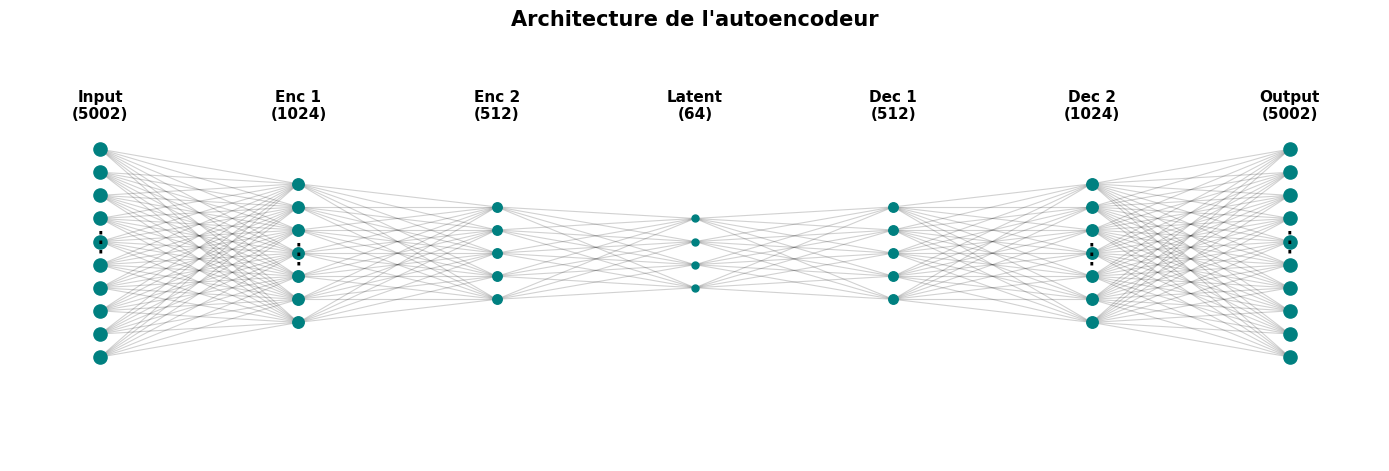

Évaluation de 49 configurations de clusters

C'est fini :)

Résumé des métriques:
    n_clusters  silhouette  davies_bouldin  calinski_harabasz          Elbow
0            2    0.211169        1.945498         133.341934  494695.718750
1            3    0.199610        1.620963         142.070526  407015.812500
2            4    0.187133        1.744890         124.529404  368093.343750
3            5    0.175881        1.738428         113.888153  338321.906250
4            6    0.179304        1.726490         104.948792  316590.937500
5            7    0.168319        1.728894          96.081131  301969.625000
6            8    0.162930        1.722530          89.543488  288939.781250
7            9    0.152762        1.724119          84.591583  277034.062500
8           10    0.151219        1.725775          79.650093  268075.562500
9           11    0.151680        1.712618          75.811188  259424.046875
10          12    0.136844        1.787257          71.275879  254155.2

/tmp/ipykernel_341109/3695099928.py:465: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


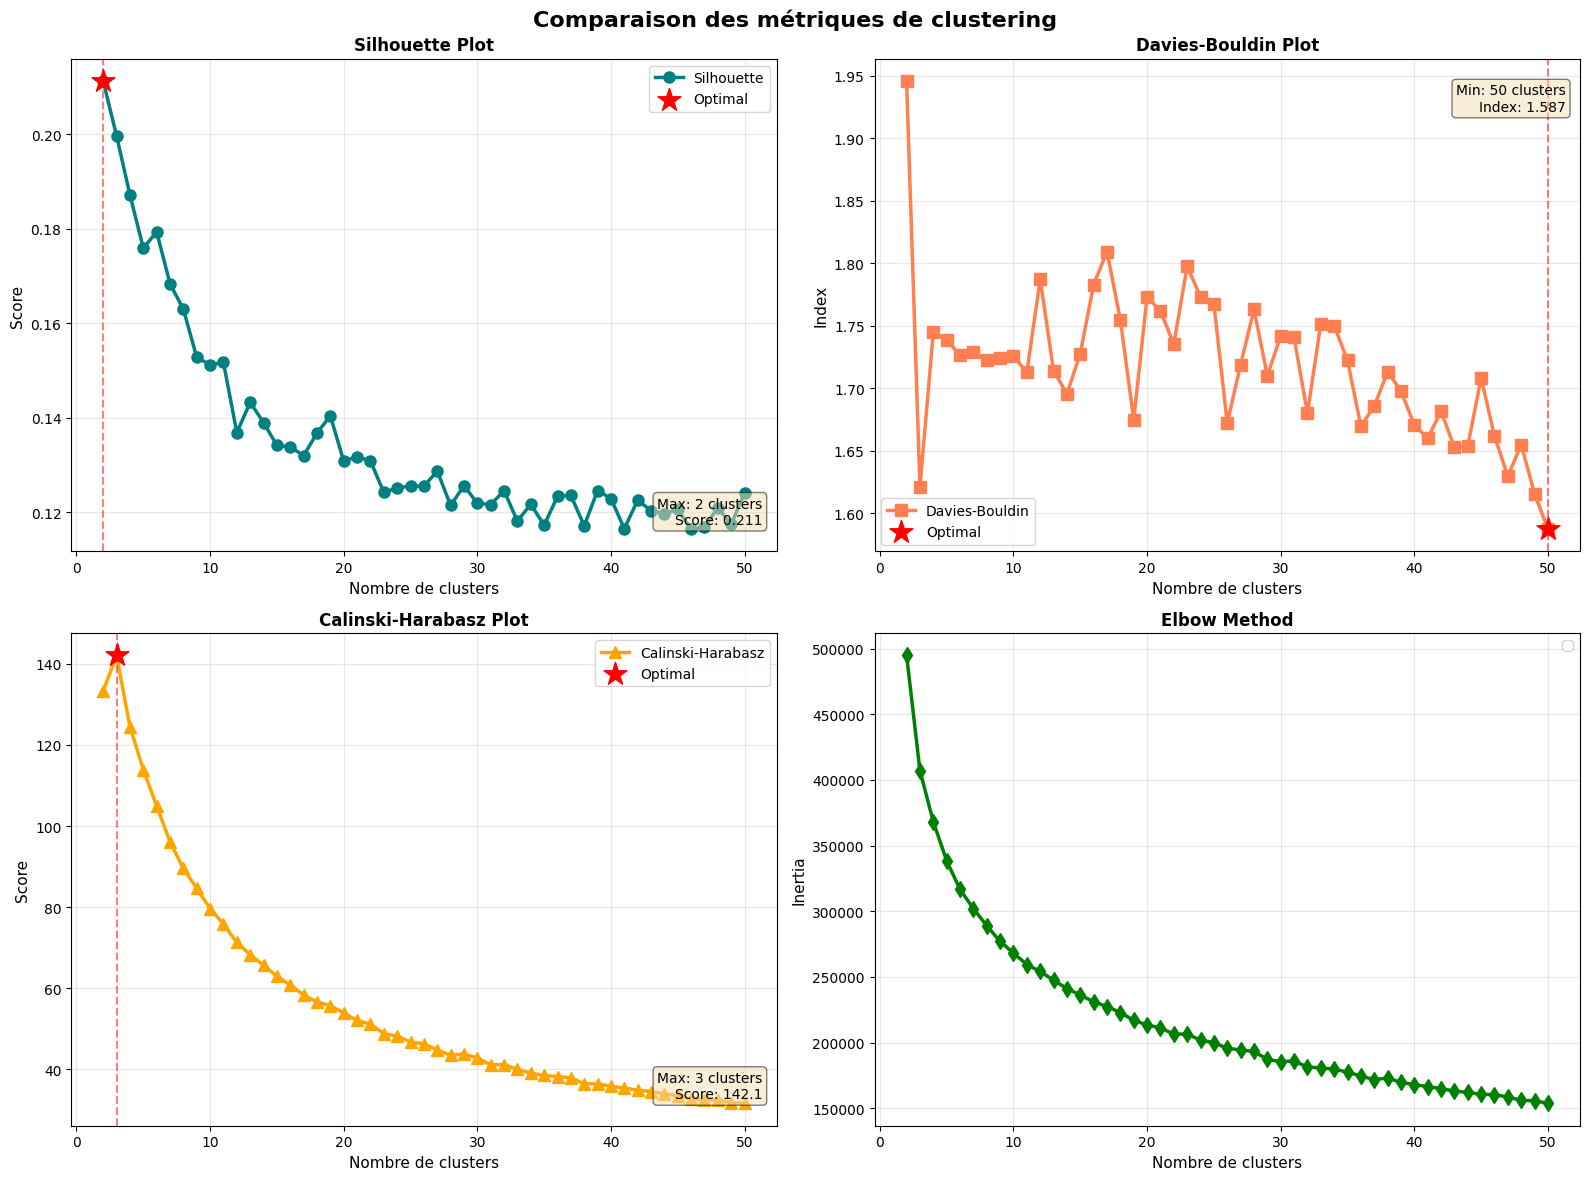


Silhouette Score optimal:2 clusters
Davies-Bouldin optimal:50 clusters
Calinski-Harabasz optimal:3 clusters
Ensemble Voting (Normalized):
  Silhouette score:     0.878
  Davies-Bouldin:       0.906
  Calinski-Harabasz:    1.000
  Elbow:                0.257
  Ensemble Score: 0.760

Donc 3 clusters recommandés

Top 3 recommandations:
  3 clusters → score 0.760
  4 clusters → score 0.630
  6 clusters → score 0.615


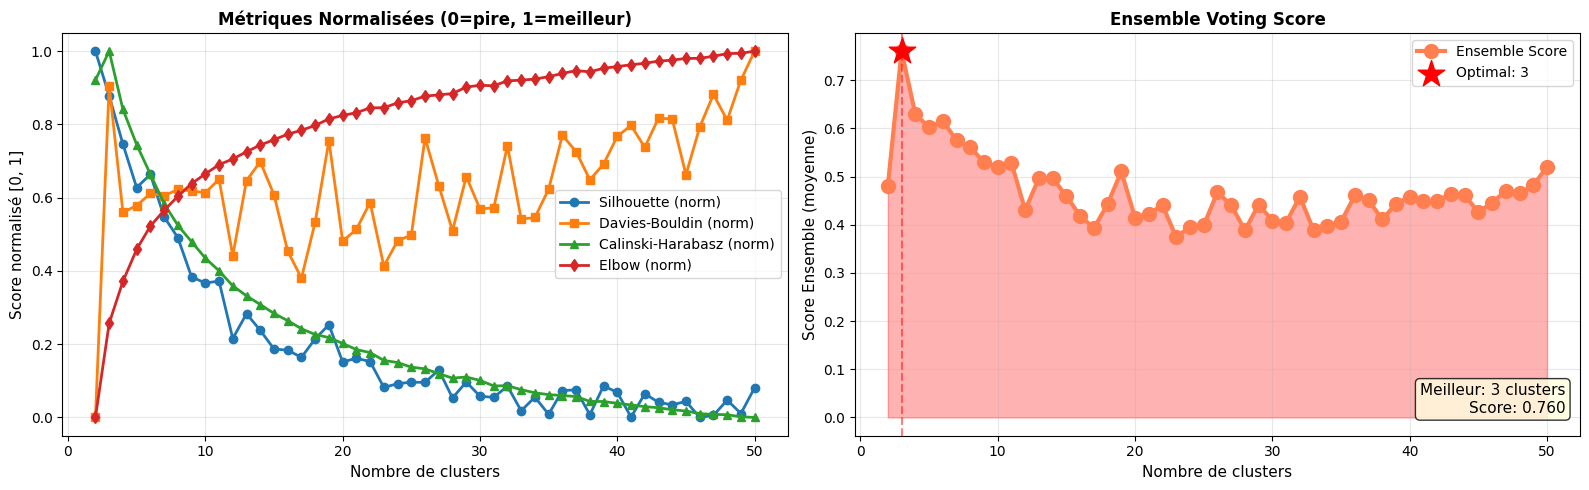

Clustering avec 3 clusters
Distribution des clusters:
Cluster 0: 168 échantillons (29.4%)
Cluster 1: 131 échantillons (22.9%)
Cluster 2: 272 échantillons (47.6%)

Plot training history



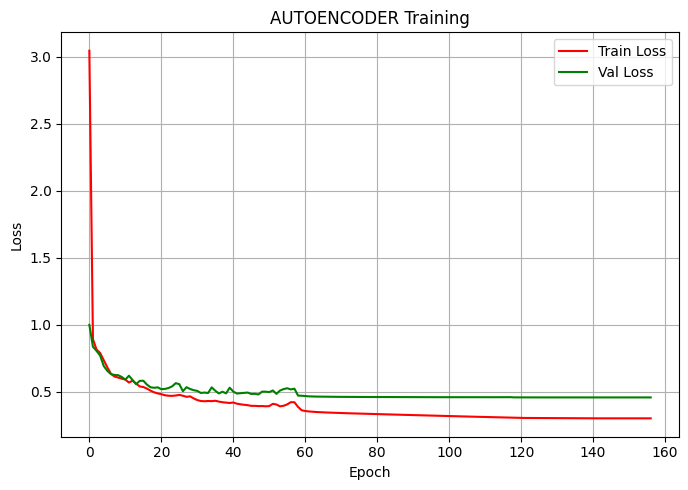

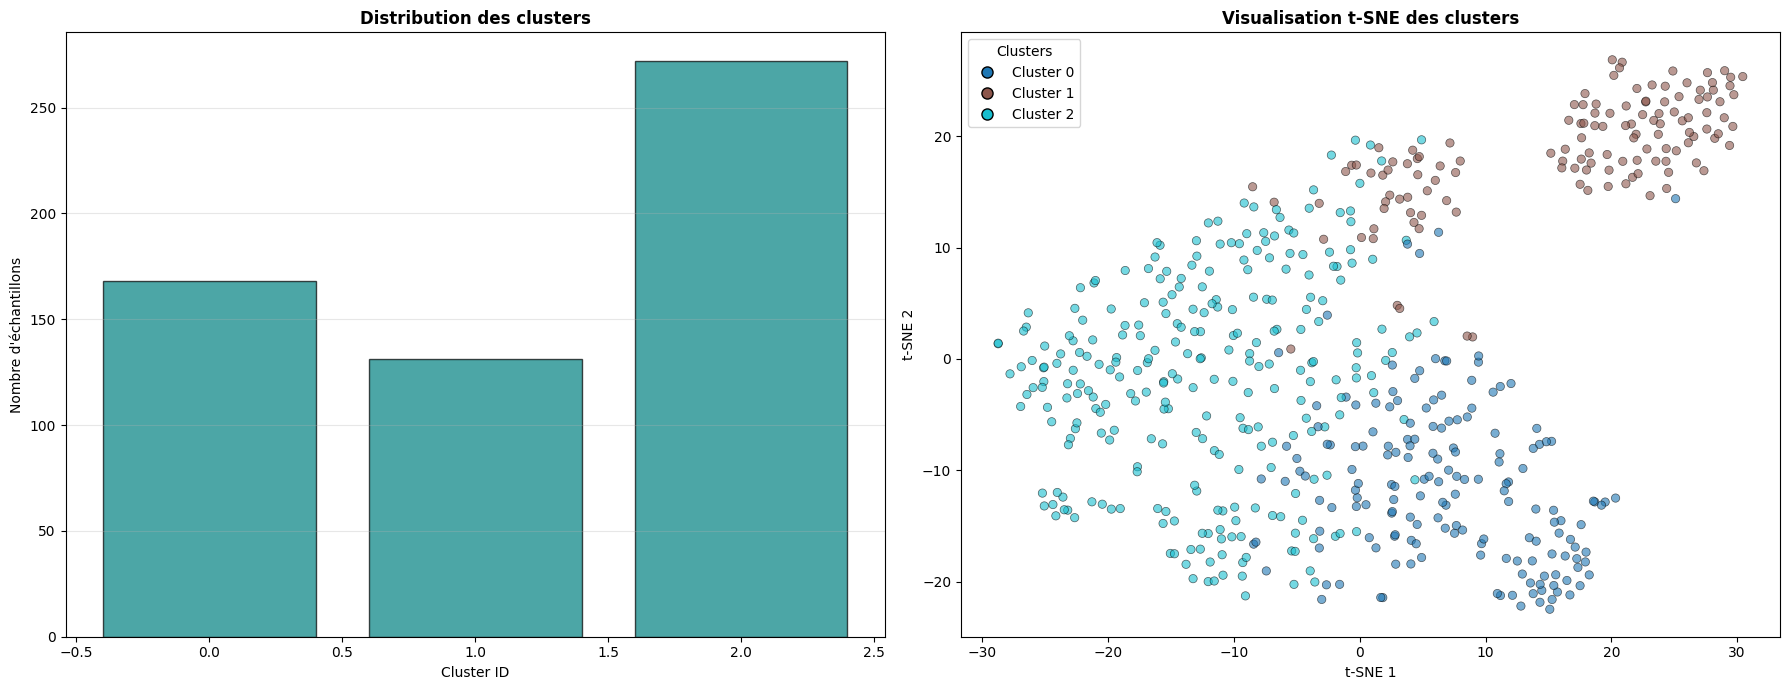

2026-01-12 09:55:19.426013: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (245, 5002) → (245, 64)
Encoder sauvegardé: models/rnaseq_tuning_encoder.keras
Autoencoder sauvegardé: models/rnaseq_tuning_autoencoder.keras

Bilan Network

Input dimension: 5002
Seed: 42

Encoder: 64 dimensions latentes



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5002)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_0 (Dense)             │ (None, 1024)           │     5,123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_0 (Dense)             │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5002)           │     5,127,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,099,040 (130.08 MB)

 Trainable params: 11,366,346 (43.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,732,694 (86.72 MB)

None
Données encodées: (245, 64)
Clustering: 3 clusters

Target de prédiction: PAM50



In [14]:
"""Initialisation de la classe"""
network = RNASeqNetwork(input_dim=X_train_scaled.shape[1], seed=seed)

"""Autoencoder and latent space encoding"""

print(f"Target de prédiction: {Target}\n")

network.build_autoencoder(
    encoding_dim=64,
    activation="relu",
    hidden_layers=[1024, 512],
    dropout_rate=0.0
)
network.train_autoencoder(
    X_train=X_train,
    epochs=300,
    batch_size=32,
    learning_rate=5e-4
)
X_train_encoded=network.encode_data(X_train)

network.plot_ae_networkx(layer_names=("Input", "Enc 1", "Enc 2", "Latent", "Dec 1", "Dec 2", "Output"),
    max_nodes_per_layer=10,
    title="Architecture de l'autoencodeur")

"""Clustering"""
network.evaluate_clustering(max_clusters=50)
network.plot_metrics_comparison()
network.select_optimal_clusters_advanced(strategy='normalized_vote') #Choisir entre normalized, z-score or simple-vote
network.plot_ensemble_voting()
y_train = network.cluster_data(X_train_encoded)
# Visualiser
print("\nPlot training history\n")
network.plot_training_history()
network.plot_cluster_analysis()

X_test_encoded=network.encode_data(X_test)
"""Sauvegarde et Bilan"""
network.save_models('models/rnaseq_tuning')
network.summary()
print(f"\nTarget de prédiction: {Target}\n")

#### Debugging and general info

In [15]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

print(f"\nnetwork.input_dim: {network.input_dim}")
print("\nStatistiques du réseau pour X_train:\n")
print(f"Min: {X_train_scaled.min().min():.4f}")
print(f"Max: {X_train_scaled.max().max():.4f}")
print(f"Mean: {X_train_scaled.mean().mean():.4f}")
print(f"Std: {X_train_scaled.std().mean():.4f}")
print("\nStatistiques du réseau pour X_test:\n")
print(f"Min: {X_test_scaled.min().min():.4f}")
print(f"Max: {X_test_scaled.max().max():.4f}")
print(f"Mean: {X_test_scaled.mean().mean():.4f}")
print(f"Std: {X_test_scaled.std().mean():.4f}")
print("\nsi mean~0 et std~1, alors MSE et relu sont bien adaptés, sinon chercher autrement\n")
print("Verification des valeurs NaN ou Inf:\n")
print(f"NaN pour X_train: {X_train_scaled.isna().sum().sum()}")
print(f"NaN pour X_test: {X_test_scaled.isna().sum().sum()}")
print(f"Inf pour X_train: {np.isinf(X_train_scaled.values).sum()}")
print(f"Inf pour X_test: {np.isinf(X_test_scaled.values).sum()}")

X_train_scaled shape: (571, 5002)
X_test_scaled shape: (245, 5002)

network.input_dim: 5002

Statistiques du réseau pour X_train:

Min: -8.2367
Max: 11.7038
Mean: -0.0000
Std: 1.0009

Statistiques du réseau pour X_test:

Min: -7.9614
Max: 10.1912
Mean: -0.0000
Std: 1.0020

si mean~0 et std~1, alors MSE et relu sont bien adaptés, sinon chercher autrement

Verification des valeurs NaN ou Inf:

NaN pour X_train: 0
NaN pour X_test: 0
Inf pour X_train: 0
Inf pour X_test: 0


In [16]:
print(network.X_encoded.shape)
print(network.labels)
print(f"nombre de clusters trouvés: {len(np.unique(network.labels))}")
# Check class balance
unique, counts = np.unique(Y_train, return_counts=True)
for cls, count in zip(label_encoder.classes_, counts):
    print(f"{cls}: {count} ({100*count/len(Y_train):.1f}%)")

(245, 64)
[1 2 2 2 2 0 2 2 0 0 0 2 0 2 1 2 1 2 0 2 1 0 1 1 0 0 2 0 2 1 2 2 2 2 2 2 2
 2 2 2 2 0 2 2 2 1 2 0 1 2 2 0 0 2 0 0 2 2 2 0 1 2 2 2 0 2 1 2 2 1 2 0 2 2
 2 1 0 0 1 1 2 1 0 0 2 0 1 0 0 2 2 2 0 0 2 1 2 0 2 2 1 0 2 0 1 2 1 2 1 2 2
 0 2 1 0 1 2 2 1 2 0 2 0 2 2 1 0 2 0 0 2 2 2 1 1 2 0 1 2 2 2 0 0 1 1 2 0 2
 1 1 2 2 2 0 0 0 0 2 2 2 1 1 0 1 2 2 2 1 0 2 2 0 1 2 2 2 0 2 2 0 2 0 0 1 1
 0 2 2 0 0 0 0 1 2 0 2 2 2 1 0 2 2 1 1 2 1 2 2 0 2 2 0 0 2 2 1 0 2 2 2 1 0
 2 2 0 2 0 1 2 0 0 1 0 0 0 1 2 0 2 2 0 2 0 2 1 2 2 1 1 0 0 2 0 1 0 0 1 2 2
 2 2 2 2 2 0 0 0 2 0 2 1 2 0 2 0 0 2 2 0 2 0 1 2 0 1 2 2 2 2 1 2 0 2 0 0 0
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 1 1 2 0 2 0 2 2 0 2 0 1 2 2 2
 2 2 0 0 0 0 0 2 0 2 2 1 2 0 2 1 1 2 0 2 2 0 2 0 2 2 2 0 2 1 2 0 1 1 2 2 2
 0 0 0 2 0 0 0 2 1 2 1 2 2 1 1 2 1 1 1 0 2 2 2 2 2 0 2 0 2 0 0 0 0 1 1 2 2
 1 1 2 1 0 0 1 2 1 1 2 1 1 2 0 0 2 0 2 2 0 2 0 2 1 2 1 2 2 2 2 2 2 0 2 0 2
 2 2 0 0 0 0 1 2 1 1 0 2 0 2 2 1 2 2 2 0 1 1 1 0 1 2 2 1 2 1 1 0 2 0 0 2 1
 1 2 1 2 1 2 0 

Données encodées: (571, 5002) → (571, 64)
MLP construit: 64 → 64 → 32 → 5
Entraînement MLP (200 epochs max) avec callbacks
Epoch 1/200


/home/pedro/miniconda3/envs/keras_env/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1535 - loss: 1.7050 - val_accuracy: 0.2348 - val_loss: 1.5701 - learning_rate: 5.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3246 - loss: 1.5446 - val_accuracy: 0.4957 - val_loss: 1.4588 - learning_rate: 5.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4627 - loss: 1.3965 - val_accuracy: 0.4087 - val_loss: 1.3789 - learning_rate: 5.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5395 - loss: 1.3052 - val_accuracy: 0.4087 - val_loss: 1.3183 - learning_rate: 5.0000e-04
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5373 - loss: 1.2425 - val_accuracy: 0.4087 - val_loss: 1.2742 - learning_rate: 5.0000e-04
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5439 - loss: 1.1788 - val_accuracy: 0.4087 - val_loss: 1.2385 - learning_rate: 5.0000e-04
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5373 - loss:

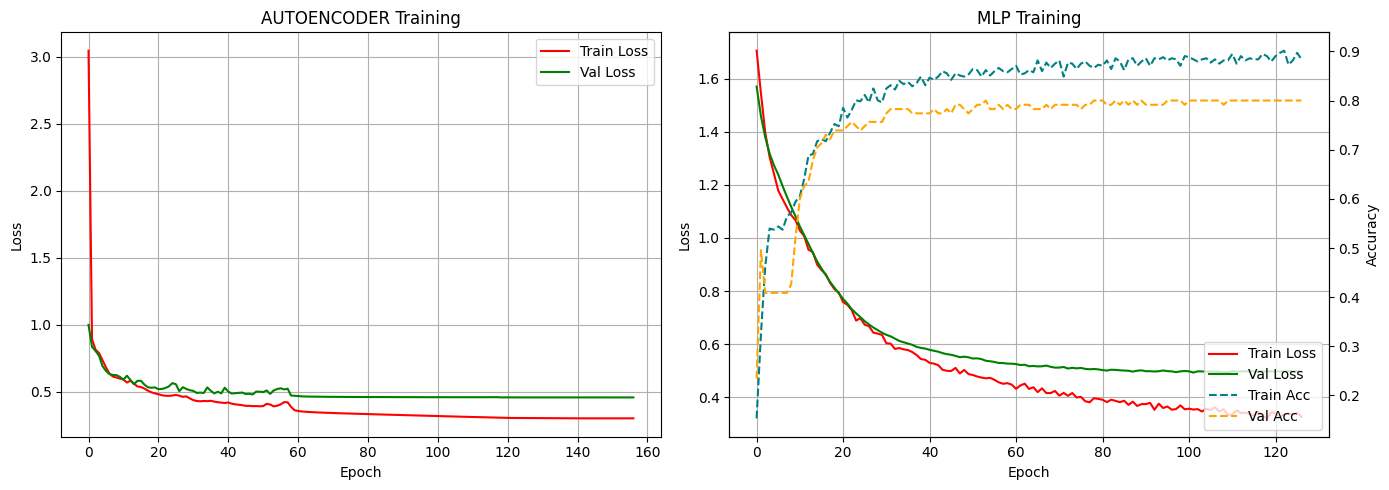


Bilan Network

Input dimension: 5002
Seed: 42

Encoder: 64 dimensions latentes



Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5002)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_0 (Dense)             │ (None, 1024)           │     5,123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoding (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_0 (Dense)             │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5002)           │     5,127,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,099,040 (130.08 MB)

 Trainable params: 11,366,346 (43.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,732,694 (86.72 MB)

None
Données encodées: (571, 64)
Clustering: 3 clusters
MLP Classifier construit



Model: "mlp_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,812 (50.05 KB)

None


In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure the model sees train features
X_train_encoded = network.encode_data(X_train)

classes = np.unique(Y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}

network.build_mlp_classifier(
    n_classes=len(classes),
    hidden_layers=[64, 32],
    activation="sigmoid",
    dropout_rate=0.1
)

network.train_mlp_classifier(
    y_train=Y_train,
    epochs=200,
    validation_split=0.2,
    learning_rate=5e-4,
    early_stop=True,
    verbose=1
)

network.plot_training_history()
network.summary()


2026-01-12 09:55:49.062234: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (245, 5002) → (245, 64)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test accuracy: 80.41%
              precision    recall  f1-score   support

       Basal       0.97      0.88      0.92        41
        Her2       0.79      0.75      0.77        20
        LumA       0.80      0.90      0.85       124
        LumB       0.71      0.66      0.69        53
      Normal       0.00      0.00      0.00         7

    accuracy                           0.80       245
   macro avg       0.66      0.64      0.65       245
weighted avg       0.79      0.80      0.79       245



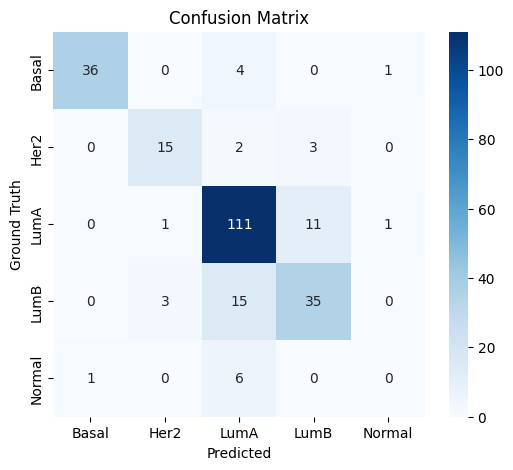

In [18]:
X_test_encoded = network.encode_data(X_test)
y_pred = network.mlp_classifier.predict(X_test_encoded).argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(f"Test accuracy: {np.mean(y_pred == Y_test)*100:.2f}%")
print(classification_report(Y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

## Test de la reproductibilité entre chaque run

In [19]:
results = []

runs=3  #nombre de runs a tester

for i in range(runs):
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Re-créer le réseau
    net_test = RNASeqNetwork(input_dim=X_train_scaled.shape[1], seed=42)
    net_test.build_autoencoder(encoding_dim=64, hidden_layers=[1024, 512], dropout_rate=0.2)
    net_test.train_autoencoder(X_train, epochs=10, batch_size=32, verbose=0)
    
    X_enc = net_test.encode_data(X_train)
    results.append(X_enc[:5, :3])  # Premiers encodages
    
# Comparer
print("Run 1:\n", results[0])
print("\nRun 2:\n", results[1])
print("\nRun 3:\n", results[2])
print("\nIdentiques?", np.allclose(results[0], results[1]) and np.allclose(results[1], results[2]))
print("\nSi les résultats sont identiques, on valide la reproductibilité entre chaque run")

Network (input_dim=5002, seed=42)
Autoencoder construit: 5002 → 1024 → 512 → 64
Entraînement autoencoder (10 epochs max, batch=32)


2026-01-12 09:55:55.800409: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Restoring model weights from the end of the best epoch: 10.
Entraînement terminé (loss finale: 0.9262)


2026-01-12 09:56:14.744636: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (571, 5002) → (571, 64)
Network (input_dim=5002, seed=42)
Autoencoder construit: 5002 → 1024 → 512 → 64
Entraînement autoencoder (10 epochs max, batch=32)


2026-01-12 09:56:20.159920: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Restoring model weights from the end of the best epoch: 10.
Entraînement terminé (loss finale: 0.9262)


2026-01-12 09:56:36.733562: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (571, 5002) → (571, 64)
Network (input_dim=5002, seed=42)
Autoencoder construit: 5002 → 1024 → 512 → 64
Entraînement autoencoder (10 epochs max, batch=32)


2026-01-12 09:56:42.890900: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Restoring model weights from the end of the best epoch: 10.
Entraînement terminé (loss finale: 0.9262)


2026-01-12 09:57:02.285372: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Données encodées: (571, 5002) → (571, 64)
Run 1:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Run 2:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Run 3:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Identiques? True

Si les résultats sont identiques, on valide la reproductibilité entre chaque run
